Loading NumPy feature files (.npy)...
 Loaded 500 videos
Example X shape: (31, 699)
Example y: [0.36666667 0.5825243  0.34579438 0.47252747 0.375     ]
Example id: zEyRyTnIw5I.005.mp4
Train: 350 | Val: 75 | Test: 75
Using: cuda


c:\Users\saath\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\modules\transformer.py:502: UserWarning: The PyTorch API of nested tensors is in prototype stage and will change in the near future. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\NestedTensorImpl.cpp:180.)
  output = torch._nested_tensor_from_mask(


Epoch 1 | Train 0.1737 | Val 0.0315 | MSE 0.0325 | MAE 0.1440 | R² -0.4094 | Acc±0.1 42.93%
Epoch 2 | Train 0.0464 | Val 0.0275 | MSE 0.0275 | MAE 0.1305 | R² -0.2074 | Acc±0.1 47.20%
Epoch 3 | Train 0.0381 | Val 0.0264 | MSE 0.0264 | MAE 0.1275 | R² -0.1575 | Acc±0.1 49.60%
Epoch 4 | Train 0.0390 | Val 0.0259 | MSE 0.0259 | MAE 0.1262 | R² -0.1328 | Acc±0.1 49.87%
Epoch 5 | Train 0.0365 | Val 0.0252 | MSE 0.0251 | MAE 0.1235 | R² -0.1032 | Acc±0.1 52.00%
Epoch 6 | Train 0.0343 | Val 0.0244 | MSE 0.0244 | MAE 0.1219 | R² -0.0709 | Acc±0.1 49.87%
Epoch 7 | Train 0.0341 | Val 0.0237 | MSE 0.0238 | MAE 0.1215 | R² -0.0448 | Acc±0.1 51.20%
Epoch 8 | Train 0.0345 | Val 0.0237 | MSE 0.0237 | MAE 0.1197 | R² -0.0439 | Acc±0.1 51.47%
Epoch 9 | Train 0.0303 | Val 0.0226 | MSE 0.0225 | MAE 0.1175 | R² 0.0113 | Acc±0.1 53.33%
Epoch 10 | Train 0.0299 | Val 0.0228 | MSE 0.0227 | MAE 0.1176 | R² 0.0058 | Acc±0.1 51.47%
Epoch 11 | Train 0.0285 | Val 0.0229 | MSE 0.0228 | MAE 0.1175 | R² -0.0031 | Acc

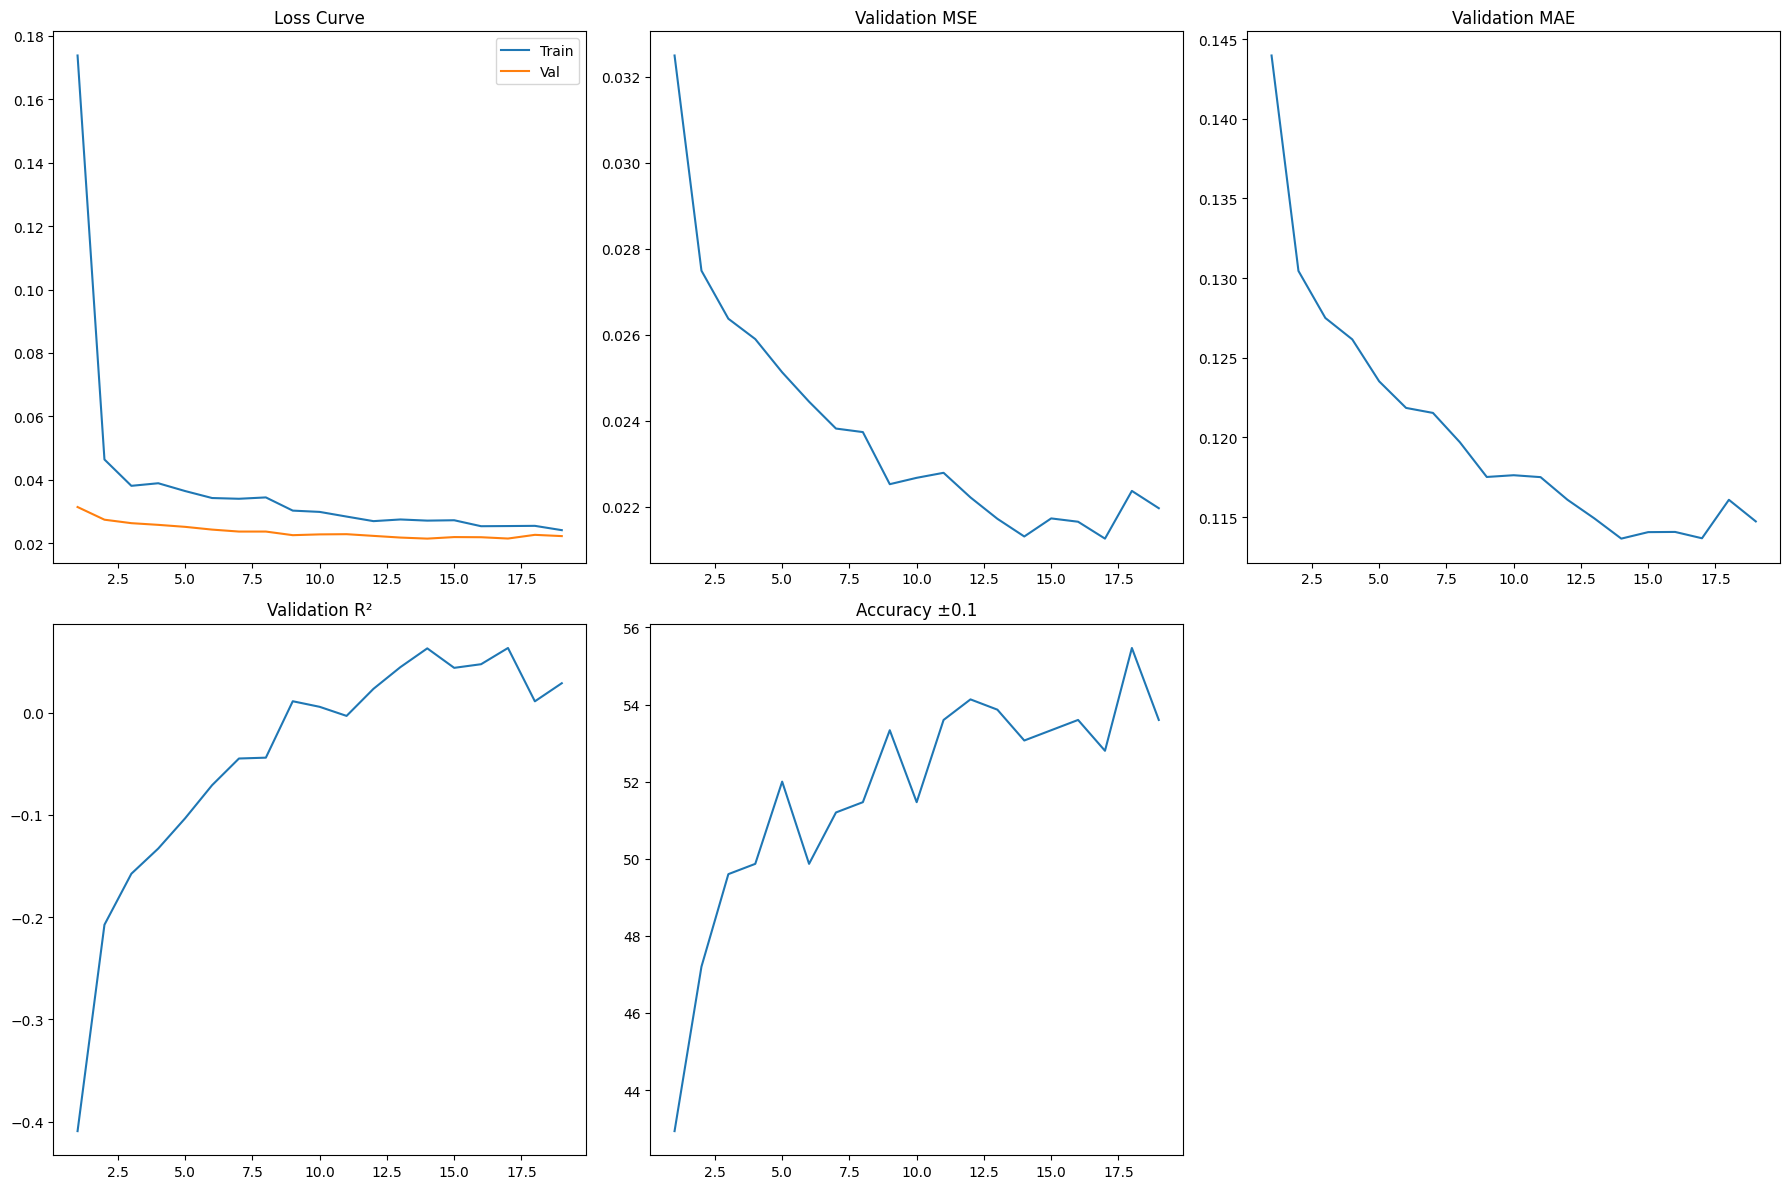


================= FINAL TEST RESULTS =================
MSE: 0.0192
MAE: 0.1117
R²:  0.1071
Accuracy ±0.1: 50.40%


In [ ]:
# ============================================================
# 📦 Install & Imports
# ============================================================


import os
import pickle
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score


# ============================================================
# 📂 Paths
# ============================================================
seq_X_path  = "seq_X.npy"
seq_y_path  = "seq_y.npy"
seq_id_path = "seq_id.npy"

print("Loading NumPy feature files (.npy)...")

# np.load is the correct function for .npy files
# seq_X_raw is an array of objects (variable-length sequences), so allow_pickle=True is needed.
seq_X_raw = np.load(seq_X_path, allow_pickle=True)
seq_y_raw = np.load(seq_y_path, allow_pickle=True)
seq_id = np.load(seq_id_path, allow_pickle=True)


# Convert to correct types
seq_X = [np.array(x, dtype=np.float32) for x in seq_X_raw]
seq_y_cleaned = [arr[0] for arr in seq_y_raw] 
seq_y = np.array(seq_y_cleaned, dtype=np.float32)
seq_id = np.array(seq_id)

N = len(seq_X)
INPUT_DIM = seq_X[0].shape[1]

print(f" Loaded {N} videos")
print("Example X shape:", seq_X[0].shape)
print("Example y:", seq_y[0])
print("Example id:", seq_id[0])



# ============================================================
# 🧾 Dataset + Collate
# ============================================================
class OceanDataset(Dataset):
    def __init__(self, X_list, y_array, ids):
        self.X_list = X_list
        self.y_array = y_array
        self.ids = ids

    def __len__(self):
        return len(self.X_list)

    def __getitem__(self, idx):
        return {
            "x": torch.tensor(self.X_list[idx], dtype=torch.float32),
            "y": torch.tensor(self.y_array[idx], dtype=torch.float32),
            "id": self.ids[idx],
        }

def collate_fn(batch):
    xs  = [item["x"] for item in batch]
    ys  = [item["y"] for item in batch]
    ids = [item["id"] for item in batch]

    lengths = [x.shape[0] for x in xs]
    max_len = max(lengths)
    feat_dim = xs[0].shape[1]
    B = len(xs)

    padded_x = torch.zeros(B, max_len, feat_dim)
    mask = torch.zeros(B, max_len)

    for i, x in enumerate(xs):
        T = x.shape[0]
        padded_x[i, :T] = x
        mask[i, :T] = 1

    y = torch.stack(ys, dim=0)
    return {"x": padded_x, "y": y, "mask": mask, "id": ids}

dataset = OceanDataset(seq_X, seq_y, seq_id)


# ============================================================
# 📊 Train / Val / Test Split
# ============================================================
train_size = int(0.7 * N)
val_size   = int(0.15 * N)
test_size  = N - train_size - val_size

train_ds, val_ds, test_ds = random_split(dataset, [train_size, val_size, test_size])

train_loader = DataLoader(train_ds, batch_size=8, shuffle=True, collate_fn=collate_fn)
val_loader   = DataLoader(val_ds, batch_size=8, shuffle=False, collate_fn=collate_fn)
test_loader  = DataLoader(test_ds, batch_size=1, shuffle=False, collate_fn=collate_fn)

print(f"Train: {len(train_ds)} | Val: {len(val_ds)} | Test: {len(test_ds)}")


# ============================================================
# 🧠 HCAFT: Encoders + Cross-Attention + BiGRU + Transformer
# ============================================================
class CrossAttentionBlock(nn.Module):
    """
    Simple cross-attention block:
    Q attends to K,V using MultiheadAttention.
    """
    def __init__(self, dim, nhead=4, dropout=0.1):
        super().__init__()
        self.mha = nn.MultiheadAttention(embed_dim=dim, num_heads=nhead, dropout=dropout, batch_first=True)
        self.ln = nn.LayerNorm(dim)
        self.ff = nn.Sequential(
            nn.Linear(dim, dim * 2),
            nn.ReLU(),
            nn.Linear(dim * 2, dim),
        )
        self.ff_ln = nn.LayerNorm(dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, q, k, v, key_padding_mask=None):
        # q,k,v: (B, T, dim)
        attn_out, _ = self.mha(q, k, v, key_padding_mask=key_padding_mask)
        x = self.ln(q + self.dropout(attn_out))
        ff_out = self.ff(x)
        x = self.ff_ln(x + self.dropout(ff_out))
        return x


class OceanHCAFT(nn.Module):
    def __init__(
        self,
        input_dim,
        clip_dim=512,
        wav_dim=187,
        clip_enc_dim=128,
        wav_enc_dim=128,
        d_model=256,
        nhead_xattn=4,
        nhead_transformer=8,
        num_layers_transformer=2,
        dim_feedforward=512,
        dropout=0.2,
    ):
        super().__init__()

        self.clip_dim = clip_dim
        self.wav_dim = wav_dim


        # -------------------------
        # 🔹 1. Modality Encoders (frame-level)
        # -------------------------
        self.clip_encoder = nn.Sequential(
            nn.Linear(clip_dim, clip_enc_dim),
            nn.ReLU(),
            nn.LayerNorm(clip_enc_dim),
        )

        self.wav_encoder = nn.Sequential(
            nn.Linear(wav_dim, wav_enc_dim),
            nn.ReLU(),
            nn.LayerNorm(wav_enc_dim),
        )

        # -------------------------
        # 🔹 2. Cross-Attention Fusion (frame-level)
        # CLIP ↔ Audio (Wav2Vec2)
        # -------------------------
        # Q = CLIP, K,V = Audio
        self.cross_clip_from_audio = CrossAttentionBlock(clip_enc_dim, nhead=nhead_xattn, dropout=dropout)
        # Q = Audio, K,V = CLIP
        self.cross_audio_from_clip = CrossAttentionBlock(wav_enc_dim, nhead=nhead_xattn, dropout=dropout)

        fused_dim = clip_enc_dim + wav_enc_dim 

        self.fuse_proj = nn.Sequential(
            nn.Linear(fused_dim, d_model),
            nn.ReLU(),
            nn.LayerNorm(d_model),
            nn.Dropout(dropout),
        )

        # -------------------------
        # 🔹 3. BiGRU (segment / local temporal modeling)
        # -------------------------
        self.bigru = nn.GRU(
            input_size=d_model,
            hidden_size=d_model // 2,
            num_layers=1,
            batch_first=True,
            bidirectional=True,
        )
        self.gru_ln = nn.LayerNorm(d_model)

        # -------------------------
        # 🔹 4. Video-level Transformer
        # -------------------------
        self.cls_token = nn.Parameter(torch.randn(1, 1, d_model))

        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=nhead_transformer,
            dim_feedforward=dim_feedforward,
            dropout=dropout,
            batch_first=True,
        )
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers_transformer)

        # -------------------------
        # 🔹 5. OCEAN Regression Head
        # -------------------------
        self.head = nn.Sequential(
            nn.Linear(d_model, d_model),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(d_model, 5),   # O, C, E, A, N
        )

    def forward(self, x, mask):
        """
        x:    (B, T, 1291)
        mask: (B, T) with 1 for valid, 0 for padded
        """
        B, T, D = x.shape

        # -------------------------
        # Split modalities
        # -------------------------
        x_clip = x[:, :, 0:self.clip_dim]  # (B, T, 512)
        x_wav  = x[:, :, self.clip_dim :self.clip_dim + self.wav_dim]  # (B, T, 768)

        # -------------------------
        # Frame-level encoding
        # -------------------------
        e_clip = self.clip_encoder(x_clip)    # (B, T, clip_enc_dim)
        e_wav  = self.wav_encoder(x_wav)      # (B, T, wav_enc_dim)

        # -------------------------
        # Cross-Attention: CLIP ↔ Audio
        # -------------------------
        # Prepare key padding masks: True where PAD
        key_padding = (mask == 0)  # (B, T)

        # CLIP attends to Audio
        clip_from_audio = self.cross_clip_from_audio(
            q=e_clip,
            k=e_wav,
            v=e_wav,
            key_padding_mask=key_padding
        )  # (B, T, clip_enc_dim)

        # Audio attends to CLIP
        audio_from_clip = self.cross_audio_from_clip(
            q=e_wav,
            k=e_clip,
            v=e_clip,
            key_padding_mask=key_padding
        )  # (B, T, wav_enc_dim)

        # Fuse all enriched features
        fused = torch.cat(
            [clip_from_audio, audio_from_clip],
            dim=-1
        )  # (B, T, fused_dim)

        fused = self.fuse_proj(fused)  # (B, T, d_model)

        # -------------------------
        # BiGRU for local temporal modeling
        # -------------------------
        gru_out, _ = self.bigru(fused)  # (B, T, d_model) since bidirectional
        gru_out = self.gru_ln(gru_out)

        # -------------------------
        # Video-level Transformer with [CLS]
        # -------------------------
        cls_tok = self.cls_token.expand(B, 1, -1)  # (B, 1, d_model)
        seq = torch.cat([cls_tok, gru_out], dim=1)  # (B, T+1, d_model)

        cls_mask = torch.ones(B, 1, device=mask.device)
        full_mask = torch.cat([cls_mask, mask], dim=1)  # (B, T+1)
        key_padding_mask = (full_mask == 0)  # True where pad

        enc = self.encoder(seq, src_key_padding_mask=key_padding_mask)  # (B, T+1, d_model)
        cls_out = enc[:, 0]  # (B, d_model)

        # -------------------------
        # OCEAN prediction
        # -------------------------
        out = self.head(cls_out)  # (B, 5)
        return out


# ============================================================
# 📏 Metrics
# ============================================================
def compute_metrics(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    r2  = r2_score(y_true, y_pred)
    acc = ((np.abs(y_true - y_pred) <= 0.1).mean()) * 100
    return mse, mae, r2, acc


# ============================================================
# 📈 Training Setup
# ============================================================
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("Using:", DEVICE)

model = OceanHCAFT(input_dim=INPUT_DIM).to(DEVICE)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-5, weight_decay=1e-5)
criterion = nn.MSELoss()

train_loss_history = []
val_loss_history   = []

val_mse_history = []
val_mae_history = []
val_r2_history  = []
val_acc_history = []

best_val = float("inf")
patience = 5
pat_ctr = 0
EPOCHS = 25

# ============================================================
# 🏋️ Training Loop
# ============================================================
for epoch in range(1, EPOCHS + 1):

    # -------- TRAIN --------
    model.train()
    train_losses = []

    for batch in train_loader:
        x, y, mask = batch["x"].to(DEVICE), batch["y"].to(DEVICE), batch["mask"].to(DEVICE)

        optimizer.zero_grad()
        preds = model(x, mask)
        loss = criterion(preds, y)
        loss.backward()
        optimizer.step()

        train_losses.append(loss.item())

    avg_train = np.mean(train_losses)
    train_loss_history.append(avg_train)

    # -------- VALIDATION --------
    model.eval()
    val_losses = []
    y_true, y_pred = [], []

    with torch.no_grad():
        for batch in val_loader:
            x, y, mask = batch["x"].to(DEVICE), batch["y"].to(DEVICE), batch["mask"].to(DEVICE)
            preds = model(x, mask)

            loss = criterion(preds, y)
            val_losses.append(loss.item())

            y_true.append(y.cpu().numpy())
            y_pred.append(preds.cpu().numpy())

    avg_val = np.mean(val_losses)
    val_loss_history.append(avg_val)

    y_true = np.vstack(y_true)
    y_pred = np.vstack(y_pred)

    mse, mae, r2, acc = compute_metrics(y_true, y_pred)

    val_mse_history.append(mse)
    val_mae_history.append(mae)
    val_r2_history.append(r2)
    val_acc_history.append(acc)

    print(f"Epoch {epoch} | Train {avg_train:.4f} | Val {avg_val:.4f} | "
          f"MSE {mse:.4f} | MAE {mae:.4f} | R² {r2:.4f} | Acc±0.1 {acc:.2f}%")

    # Early stopping
    if avg_val < best_val:
        best_val = avg_val
        best_state = model.state_dict()
        pat_ctr = 0
    else:
        pat_ctr += 1
        if pat_ctr >= patience:
            print("Early stopping triggered")
            break
        
model_path = "ocean_HCAFT_transformer_best.pth"
torch.save(best_state, model_path)
print(f"Best model saved to {model_path}")

model.load_state_dict(best_state)


# ============================================================
# 📈 Plot Metrics
# ============================================================
epochs = range(1, len(train_loss_history) + 1)

plt.figure(figsize=(18, 12))

plt.subplot(2, 3, 1)
plt.plot(epochs, train_loss_history, label="Train")
plt.plot(epochs, val_loss_history, label="Val")
plt.title("Loss Curve")
plt.legend()

plt.subplot(2, 3, 2)
plt.plot(epochs, val_mse_history)
plt.title("Validation MSE")

plt.subplot(2, 3, 3)
plt.plot(epochs, val_mae_history)
plt.title("Validation MAE")

plt.subplot(2, 3, 4)
plt.plot(epochs, val_r2_history)
plt.title("Validation R²")

plt.subplot(2, 3, 5)
plt.plot(epochs, val_acc_history)
plt.title("Accuracy ±0.1")

plt.tight_layout()
plt.show()


# ============================================================
# 🧪 Final Test Evaluation
# ============================================================
model.eval()
true_list, pred_list = [], []

with torch.no_grad():
    for batch in test_loader:
        x, y, mask = batch["x"].to(DEVICE), batch["y"].to(DEVICE), batch["mask"].to(DEVICE)
        preds = model(x, mask)
        true_list.append(y.cpu().numpy())
        pred_list.append(preds.cpu().numpy())

true_list = np.vstack(true_list)
pred_list = np.vstack(pred_list)

mse, mae, r2, acc = compute_metrics(true_list, pred_list)

print("\n================= FINAL TEST RESULTS =================")
print(f"MSE: {mse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"R²:  {r2:.4f}")
print(f"Accuracy ±0.1: {acc:.2f}%")